### COVID-19





In [0]:
#Importing Libraries

import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os


from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
#from pandas.tools.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [6]:
#loading data
path="/casos_covid19_colombia.csv"
df=pd.read_csv(path) 
df.head()

,ID de caso,Fecha de diagnóstico,Ciudad de ubicación,Atención,Edad,Sexo,Tipo,País de procedencia,Estado,Departamento,Fecha de Estado
0,1,6/3/2020,Bogotá,casa,10 a 19,F,Importado,Italia,Recuperado,Bogotá,6/3/2020
1,2,9/3/2020,Buga,hospital,30 a 39,M,Importado,España,Recuperado,Valle,NaN
2,3,9/3/2020,Medellín,casa,50 a 59,F,Importado,España,Recuperado,Antioquia,NaN
3,4,11/3/2020,Medellín,casa,50 a 59,M,Relacionado,Colombia,Activo,Antioquia,NaN
4,5,11/3/2020,Medellín,casa,20 a 29,M,Relacionado,Colombia,Activo,Antioquia,NaN


In [7]:
#dim
len(df)

378

In [8]:
df.columns

Index(['ID de caso', 'Fecha de diagnóstico', 'Ciudad de ubicación', 'Atención',
       'Edad', 'Sexo', 'Tipo', 'País de procedencia', 'Estado', 'Departamento',
       'Fecha de Estado'],
      dtype='object')

In [9]:
df.columns = ['id_caso','fecha', 'ciudad_ubicacion', 'atencion', 'edad', 'sexo', 'tipo','pais_procedencia','estado','dpto','fecha_estado']
df.head(3)

,id_caso,fecha,ciudad_ubicacion,atencion,edad,sexo,tipo,pais_procedencia,estado,dpto,fecha_estado
0,1,6/3/2020,Bogotá,casa,10 a 19,F,Importado,Italia,Recuperado,Bogotá,6/3/2020
1,2,9/3/2020,Buga,hospital,30 a 39,M,Importado,España,Recuperado,Valle,NaN
2,3,9/3/2020,Medellín,casa,50 a 59,F,Importado,España,Recuperado,Antioquia,NaN


In [76]:
df.fecha=pd.to_datetime(df.fecha, format='%d/%m/%Y')
df.set_index('fecha', inplace=True)
df.head(3)

AttributeError: ignored

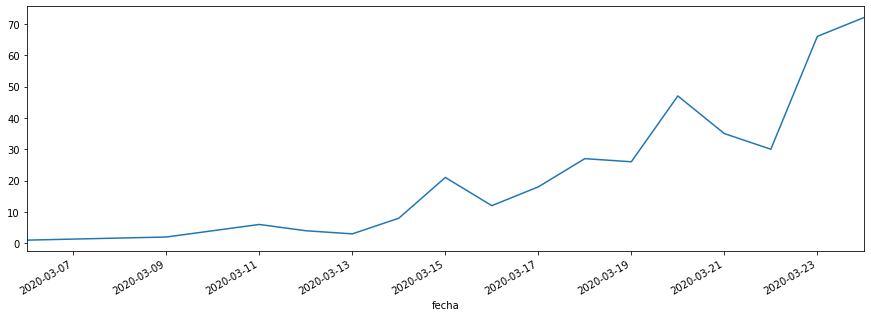

In [22]:
ts = df.groupby("fecha")["id_caso"].count()
ts.plot(figsize=(15,5))
data = pd.DataFrame(df.groupby("fecha")["id_caso"].count())

In [12]:
ts.describe()

count    16.000000
mean     23.625000
std      22.192717
min       1.000000
25%       5.500000
50%      19.500000
75%      31.250000
max      72.000000
Name: id_caso, dtype: float64

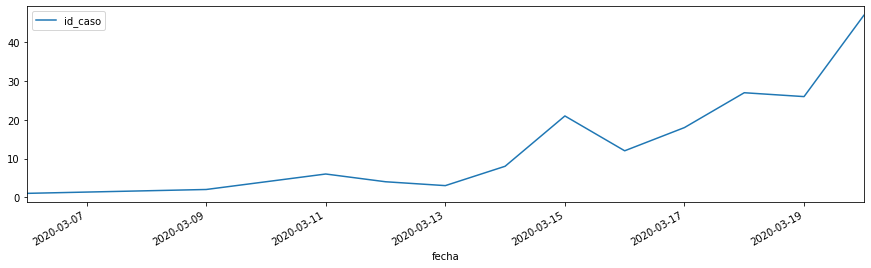

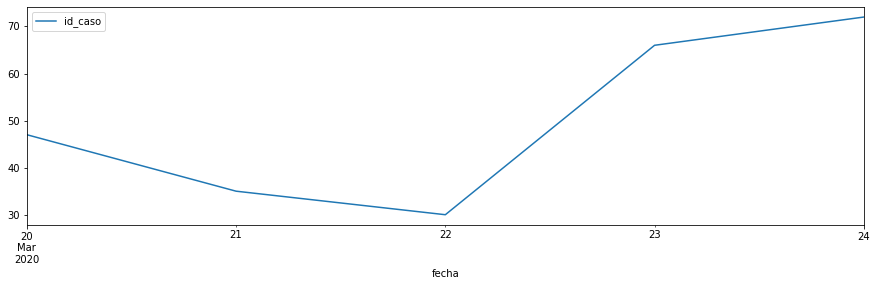

In [23]:
test_period = int(data.shape[0]*0.8)
train = data.iloc[:12,].dropna()
test = data.iloc[12:,].dropna()
train.plot(figsize=(15,4))
test.plot(figsize=(15,4))

**Dickey Fuller's Test**

In [34]:
t = sm.tsa.adfuller(train.id_caso, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                 1.497833
p-value                        0.997516
#Lags Used                     4.000000
Number of Observations Used    7.000000
dtype: float64

In [0]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [36]:
t  = sm.tsa.adfuller(difference(train.id_caso,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                 -3.600478
p-value                         0.005752
#Lags Used                      0.000000
Number of Observations Used    10.000000
dtype: float64

Por lo tanto, la serie no es estacionaria.

**Seasonal Decomposition**



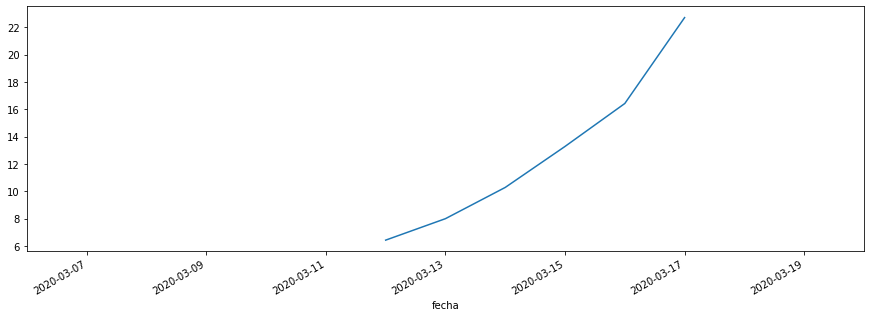

In [47]:
s = sm.tsa.seasonal_decompose(train.id_caso,freq=7)
s.trend.plot(figsize=(15,5))

**SARIMAX**


In [65]:
model = sm.tsa.statespace.SARIMAX(train['id_caso'], order=(0,1,2),trend='c')
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                id_caso   No. Observations:                   12
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -36.933
Date:                Thu, 26 Mar 2020   AIC                             81.865
Time:                        21:22:44   BIC                             83.457
Sample:                             0   HQIC                            80.862
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4541      1.962      1.761      0.078      -0.391       7.299
ma.L1         -0.9197    962.398     -0.001      0.999   -1887.186    1885.346
ma.L2         -0.0800     77.409     -0.001      0.999    -151.800     151.640
sigma2        39.0078   3.75e+04      0.001      0.999   -7.35e+04    7.36e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 3.78
Prob(Q):                               nan   Prob(JB):                         0.15
Heteroskedasticity (H):               2.61   Skew:                             1.31
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

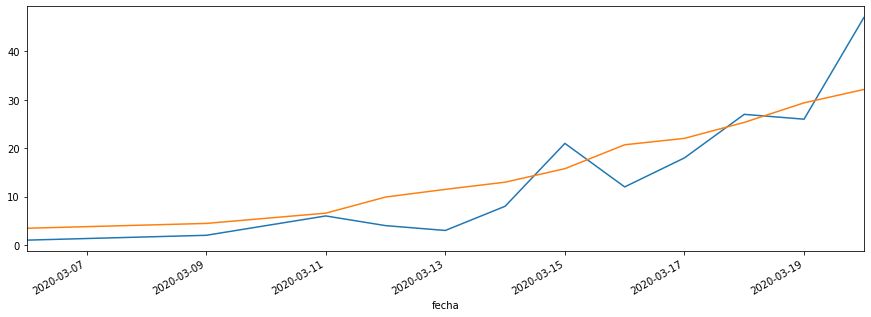

In [71]:
#model fit
train['id_caso'].plot(figsize=(15,5))
model_fit.fittedvalues.plot()
plt.show()

In [89]:
#prediction
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1)
test['predicted'] = predict.values
test.tail(5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,id_caso,predicted,residual
fecha,,,
2020-03-20,47,38.251474,8.748526
2020-03-21,35,40.613693,5.613693
2020-03-22,30,44.067750,14.067750
2020-03-23,66,47.521807,18.478193
2020-03-24,72,50.975864,21.024136


In [80]:
#score
test['residual'] = abs(test['id_caso']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['id_caso']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 13.586459885938487
MAPE: 27.74859236526055


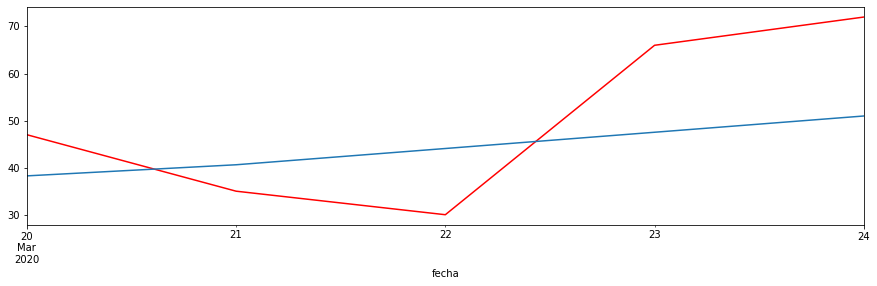

In [84]:
test['id_caso'].plot(figsize=(15,4),color = 'red')
test['predicted'].plot()
plt.show()

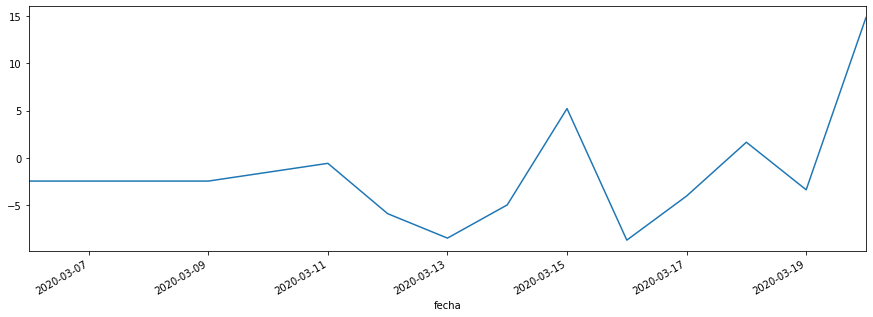

In [85]:
model_fit.resid.plot(figsize= (15,5))

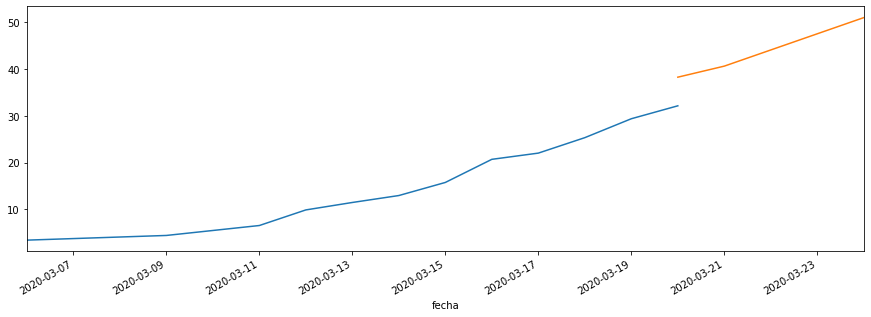

In [86]:
model_fit.fittedvalues.plot(figsize = (15,5))
test.predicted.plot()